<a href="https://colab.research.google.com/github/RegiTelma/ComputerVision/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class AutoEncoder(tf.keras.Model):

  def __init__(self,latent_dim): #constructor
    super().__init__()

    self.latent_dim=latent_dim

    #Encoder
    self.encoder_reshape=tf.keras.layers.Reshape((784,))
    self.encoder_fc1=tf.keras.layers.Dense(256,activation="relu")
    self.encoder_fc2=tf.keras.layers.Dense(latent_dim, activation="relu") #latent_dim-32

    #Decoder
    self.decoder_fc1=tf.keras.layers.Dense(256, activation="relu")
    self.decoder_fc2=tf.keras.layers.Dense(784, activation="sigmoid")
    self.decoder_reshape=tf.keras.layers.Reshape((28,28,1))

    self._build_graph()

  def _build_graph(self):
    input_shape=(28,28,1)
    self.build((None,) + input_shape)
    inputs=tf.keras.Input(shape=input_shape)
    _=self.call(inputs)

  def call(self,x):
    z=self.encode(x)
    y=self.decode(z)
    return y

  def encode(self,x):
    z=self.encoder_reshape(x)
    z=self.encoder_fc1(z)
    z=self.encoder_fc2(z)
    return z

  def decode(self,z):
    y=self.decoder_fc1(z)
    y=self.decoder_fc2(y)
    y=self.decoder_reshape(y)
    return y


autoencoder=AutoEncoder(32)
autoencoder.summary()
#print(autoencoder.latent_dim)
#print(autoencoder.encoder_reshape)
prediction=autoencoder.predict(np.random.random((1, 28, 28, 1)))
#autoencoder.summary()

autoencoder.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy"
)



Model: "auto_encoder_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_17 (Reshape)        (None, 784)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               200960    
                                                                 
 dense_29 (Dense)            (None, 32)                8224      
                                                                 
 dense_30 (Dense)            (None, 256)               8448      
                                                                 
 dense_31 (Dense)            (None, 784)               201488    
                                                                 
 reshape_18 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
Total params: 419,120
Trainable params: 419,120
Non

In [17]:
mnist_train_original,mnist_validate_original,mnist_test_original=tfds.load(
    "mnist",
    split=["train","test[:50%]","test[50%:]"],
    as_supervised=True
)

In [18]:
def encode(image):
  image=tf.image.convert_image_dtype(image,tf.float32)
  return image,image  #input,output


mnist_train=mnist_train_original.map(lambda image, _: encode(image)).cache().shuffle(60000)
mnist_validate=mnist_validate_original.map(lambda image, _: encode(image)).cache()
mnist_test=mnist_test_original.map(lambda image, _: encode(image)).cache()



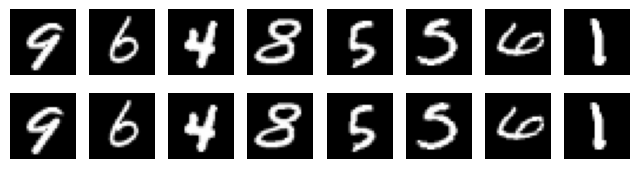

In [19]:
def render_dataset():
  index=1
  plt.figure(figsize=(8,2))
  for image_in, image_out in mnist_train.take(8):
    plt.subplot(2,8,index)
    plt.axis("off")
    plt.imshow(image_in,cmap="gray")

    plt.subplot(2,8,index + 8)
    plt.axis("off")
    plt.imshow(image_out,cmap="gray")

    index+=1


render_dataset()

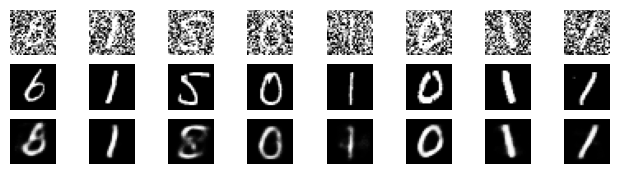

In [37]:
def render_predictions():
  index=1
  plt.figure(figsize=(8,2))
  for image_in, image_out in mnist_test.take(8):
    plt.subplot(3,8,index)
    plt.axis("off")
    plt.imshow(image_in,cmap="gray")

    plt.subplot(3,8,index + 8)
    plt.axis("off")
    plt.imshow(image_out,cmap="gray")

    prediction=autoencoder.predict(
        image_in.numpy().reshape((1,28,28,1)), verbose=0
        )[0]
    plt.subplot(3,8,index + 16)
    plt.axis("off")
    plt.imshow(prediction,cmap="gray")

    index+=1


render_predictions()

In [38]:
_= autoencoder.fit(
    mnist_train.batch(256),
    epochs=50,
    validation_data=mnist_validate.batch(256)
)

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1266 - val_loss: 0.1297
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1262 - val_loss: 0.1301
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1258 - val_loss: 0.1305
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1257 - val_loss: 0.1288
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1254 - val_loss: 0.1301
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1250 - val_loss: 0.1291
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1247 - val_loss: 0.1286
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1245 - val_loss: 0.1275
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1242 - val_loss: 0.1291
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1240 - val_loss: 0.1279

loss is between output and predicted output

1st row-input

2nd row- output

3rd row-predicted output

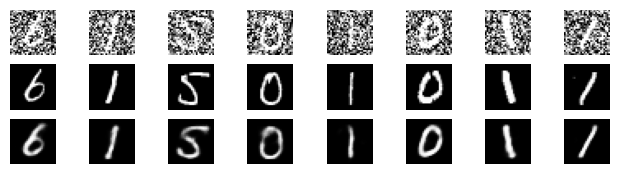

In [39]:
render_predictions()

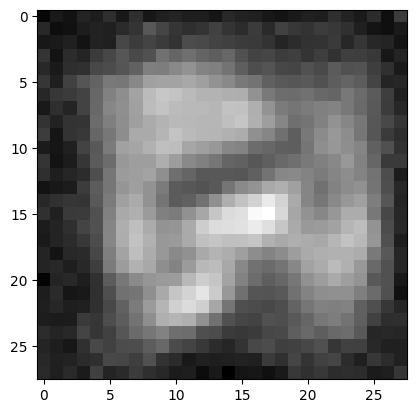

In [40]:
z=np.random.random((1,32))
picture=autoencoder.decode(z)[0]
plt.imshow(picture,cmap="gray")

#Denoising AutoEncoder

In [41]:
autoencoder=AutoEncoder(32)
autoencoder.compile(optimizer="rmsprop",loss="binary_crossentropy")

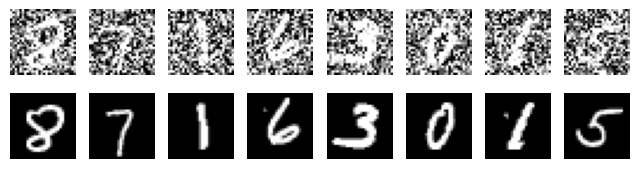

In [42]:
def encode(image):
  image=tf.image.convert_image_dtype(image,tf.float32)
  noise=tf.random.normal(
      shape=image.shape,
      mean=0.5,
      stddev=0.5,
      dtype=tf.float32
  )
  return tf.clip_by_value(image + noise,0.0,1.0), image


mnist_train=mnist_train_original.map(lambda image, _: encode(image)).cache().shuffle(60000)
mnist_validate=mnist_validate_original.map(lambda image, _: encode(image)).cache()
mnist_test=mnist_test_original.map(lambda image, _: encode(image)).cache()

render_dataset()

Epoch 1/50
235/235 [==============================] - 3s 6ms/step - loss: 0.2748 - val_loss: 0.2547
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2455 - val_loss: 0.2353
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2217 - val_loss: 0.2099
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2057 - val_loss: 0.2004
Epoch 5/50
235/235 [==============================] - 2s 6ms/step - loss: 0.1948 - val_loss: 0.1892
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1867 - val_loss: 0.1819
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1802 - val_loss: 0.1737
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1751 - val_loss: 0.1758
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1708 - val_loss: 0.1654
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1673 - val_loss: 0.1686

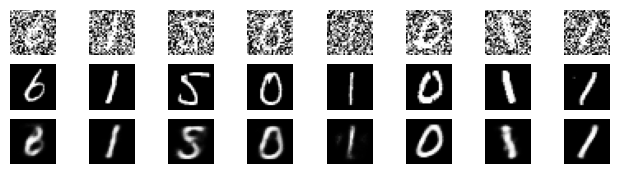

In [43]:
_= autoencoder.fit(
    mnist_train.batch(256),
    epochs=50,
    validation_data=mnist_validate.batch(256)
)

render_predictions()

#Variational AutoEncoder

In [45]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

1/1 [==============================] - 0s 328ms/step
Model: "variational_auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_24 (Reshape)        (None, 784)               0         
                                                                 
 dense_43 (Dense)            (None, 256)               200960    
                                                                 
 dense_44 (Dense)            (None, 32)                8224      
                                                                 
 dense_45 (Dense)            multiple                  0 (unused)
                                                                 
 sampling (Sampling)         (None, 32)                0         
                                                                 
 dense_46 (Dense)            (None, 256)               8448      
                                                     

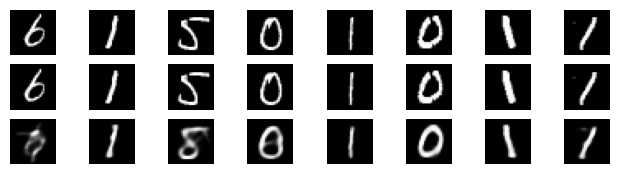

In [46]:
class VariationalAutoEncoder(tf.keras.Model):

    def __init__(self, latent_dim): # Constructor.
        super().__init__()

        self.latent_dim = latent_dim

        # Encoder.
        self.encoder_reshape = tf.keras.layers.Reshape((784,))
        self.encoder_fc1 = tf.keras.layers.Dense(256, activation="relu")
        self.encoder_fc_mean = tf.keras.layers.Dense(latent_dim, activation="linear")
        self.encoder_fc_logvar = tf.keras.layers.Dense(latent_dim, activation="linear")

        # Sampling
        self.sampling = Sampling()

        # Decoder.
        self.decoder_fc1 = tf.keras.layers.Dense(256, activation="relu")
        self.decoder_fc2 = tf.keras.layers.Dense(784, activation="sigmoid")
        self.decoder_reshape = tf.keras.layers.Reshape((28, 28, 1))

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        self._build_graph()

    def _build_graph(self):
        input_shape = (28, 28, 1)
        self.build((None,) + input_shape)
        inputs = tf.keras.Input(shape=input_shape)
        _ = self.call(inputs)

    def call(self, x):
        z_mean, z_logvar, z = self.encode(x)
        y = self.decode(z)
        return y

    def encode(self, x):
        #z = self.encoder_fc2(self.encoder_fc1(self.encoder_reshape(x)))
        z = self.encoder_reshape(x)
        z = self.encoder_fc1(z)
        z_mean = self.encoder_fc_mean(z)
        z_logvar = self.encoder_fc_mean(z)
        z = self.sampling([z_mean, z_logvar])
        return z_mean, z_logvar, z

    def decode(self, z):
        y = self.decoder_fc1(z)
        y = self.decoder_fc2(y)
        y = self.decoder_reshape(y)
        return y

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data_input, data_output = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encode(data_input)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data_output, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


autoencoder = VariationalAutoEncoder(32)
#autoencoder.summary()
prediction = autoencoder.predict(np.random.random((1, 28, 28, 1)))
autoencoder.summary()

autoencoder.compile(
    optimizer="adam",
    loss="binary_crossentropy"
)

def encode(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image # input, output

mnist_train = mnist_train_original.map(lambda image, _: encode(image)).cache().shuffle(60000)
mnist_validate = mnist_validate_original.map(lambda image, _: encode(image)).cache()
mnist_test = mnist_test_original.map(lambda image, _: encode(image)).cache()

_ = autoencoder.fit(
    mnist_train.batch(256),
    epochs=50,
    #validation_data=mnist_validate.batch(256)
)

render_predictions()

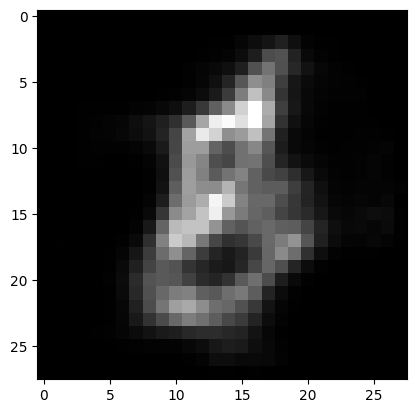

In [47]:
z = np.random.normal(0.0, 1.0, (1, 32))
picture = autoencoder.decode(z)[0]
plt.imshow(picture, cmap="gray")